In [1]:
from IPython.display import HTML, clear_output
import sys
sys.path.append("/home/ec2-user/SageMaker/")
import boto3
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta, date
from utils import Athena_Query, s3, LabelStore
from utils.sql_query import SqlQuery

from utils.waveform_viewer2 import Waveform_Chart
from utils.waveform_viewer2 import Waveform_Extract, Waveform_Helper
wh = Waveform_Helper()

athena = Athena_Query()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Matplotlib is building the font cache; this may take a moment.


In [2]:
hrv = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/allpatients_hrvdata_problem_new.csv")
#hrv = pd.read_csv("s3://hrv-and-others-relationship/HRV_for_each_onehr/12_hr.csv")
#hrv = hrv.drop(columns=['problemtype'])
hrv.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,patientid,SDNN (ms),SDANN (ms),MeanRR (ms),RMSSD (ms),pNN50 (%),P_VLF (s^2/Hz),P_LF (s^2/Hz),P_HF (s^2/Hz),P_VLF (%),...,Lmean (bts),Lmax (bts),Vmean (bts),Vmax (bts),SD1,SD2,alpha1,alpha2,problemtype,HF/LF
0,A04E1EBC0535DE29A00B2EA348ACDCEF,1327.07,6001.59,282.09,1356.91,0.76,3309.843,3095.212,7033.506,24.629,...,1825.99,3653,1820.00,3640,230.12,861.99,0.20,0.20,MED,2.272727
1,C1EF6CAB75536C2BA0655FF39DA2BB05,1183.60,6141.06,161.35,1194.64,0.22,7982.744,7335.211,15792.172,25.660,...,3205.50,6410,3204.50,6407,473.13,1158.70,0.51,0.57,SUR,2.155172
2,AA06EE2EEEC3006BB4509F21148674A8,14.81,8.96,121.77,122.68,0.00,0.011,0.002,0.002,73.333,...,3642.74,6800,2654.85,4655,0.34,20.69,1.60,1.24,SUR,1.000000
3,46724130B7670EF60E88DCEF22BFB3EB,14.62,14.43,179.30,179.98,0.00,0.004,0.000,0.000,100.000,...,664.19,1161,379.16,567,1.37,19.47,1.46,0.79,MED,NaN
4,F17AFD1A9A5DDE420D6792232A2DF63C,3946.99,399.79,344.84,3962.83,1.02,268175.571,103890.174,113141.276,55.270,...,1224.00,2447,1223.00,2445,1191.43,3256.10,0.75,0.33,MED,1.089325


In [3]:
vital = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/vital_slope_mean_std_filter_28.csv")
vital.head()

,patientid,HR (mean),Diastolic BP (mean),Systolic BP (mean),ABP Mean (mean),SpO2 (mean),Respiratory rate (mean),HR (slope),Diastolic BP (slope),Systolic BP (slope),ABP Mean (slope),SpO2 (slope),Respiratory rate (slope),HR_std,Diastolic BP_std,Systolic BP_std,ABP Mean_std,SpO2_std,Respiratory rate_std
0,CF654A159982FD3A280A1EB702D5E32E,89.709427,54.529332,122.996831,73.401276,99.684460,19.032981,0.130137,-0.423174,1.344681,-0.094820,-0.017567,0.246270,3.674501,4.558671,11.309684,4.121025,0.526237,1.724865
1,7A428D52AB03B0320865FC9463AD6E24,72.559371,NaN,NaN,NaN,95.432127,23.345642,-1.056293,NaN,NaN,NaN,0.247387,0.161037,4.987653,NaN,NaN,NaN,1.428946,2.422367
2,94DBBFF28CE57A3067A103459227D410,100.952846,71.707114,119.946250,86.904775,99.259423,22.925705,-0.923201,-0.516018,-0.027752,-0.234851,-0.024026,-0.171506,6.658241,3.070629,6.479115,3.087090,0.750736,3.967236
3,C9961BEC4697C5049B2091F84FFAC7DB,61.309293,NaN,NaN,NaN,99.984743,15.762829,-0.124506,NaN,NaN,NaN,-0.000622,-0.200693,3.559009,NaN,NaN,NaN,0.037940,3.335912
4,C5FF715D7605FB1394C025EB578FD8A3,71.234452,65.053117,137.727945,88.685776,99.645125,15.896674,0.484955,-0.277545,0.508155,-0.200911,-0.020944,0.048626,3.823054,2.341800,5.447488,3.491605,0.451994,0.296676


In [4]:
gcs = pd.read_excel("s3://hrv-and-others-relationship/features/trauma_final_features/GCS_new.xlsx")
gcs.rename(columns={'Total_final': 'GCS_final'}, inplace=True)
gcs.head()

,patientid,GCS(eyes)_add,GCS(motor)_add,GCS(verbal)_add,GCS(eyes)_12hr,GCS(motor)_12hr,GCS(verbal)_12hr,GCS(eyes)_final,GCS(motor)_final,GCS(verbal)_final,final from add,Total_add,Total_12hr,GCS_final
0,CF654A159982FD3A280A1EB702D5E32E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7A428D52AB03B0320865FC9463AD6E24,NaN,NaN,NaN,4.0,6.0,5.0,4.0,6.0,5.0,23.0,NaN,15.0,15.0
2,94DBBFF28CE57A3067A103459227D410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C9961BEC4697C5049B2091F84FFAC7DB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA06EE2EEEC3006BB4509F21148674A8,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,17.0,NaN,3.0,3.0


In [5]:
lab = pd.read_excel("s3://hrv-and-others-relationship/features/trauma_final_features/laboratory data.xlsx")
lab.head()

,patientid,so2,po2,pco2,hemoglobin,carboxyhemoglobin,methemoglobin,chloride,calcium,anion_gap,temperature,potassium,sodium,lactate,glucose
0,CF654A159982FD3A280A1EB702D5E32E,97.0,88.0,35.0,9.3,0.7,0.2,111.0,1.12,2.0,37.1,4.1,138.0,0.8,117.10
1,7A428D52AB03B0320865FC9463AD6E24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,94DBBFF28CE57A3067A103459227D410,97.0,97.0,40.0,10.2,0.3,0.3,114.0,1.11,4.0,37.1,3.5,146.0,1.0,127.91
3,C9961BEC4697C5049B2091F84FFAC7DB,98.0,103.0,44.0,12.6,0.2,0.3,111.0,1.11,2.0,36.1,3.2,137.0,0.7,77.46
4,AA06EE2EEEC3006BB4509F21148674A8,99.0,177.0,37.0,11.2,1.3,0.9,116.0,1.12,8.0,37.5,5.2,140.0,1.7,118.50


In [8]:
# patient_ids = hrv['patientid']
# trauma_age = pd.read_csv("s3://trauma-patient-details/geomatric_lab_data/trauma_age.csv")
# age = trauma_age[trauma_age['patientid'].isin(patient_ids)]
# age.head()

In [6]:
age = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/geomatric_los.csv")
age['gender'] = age['gender'].replace({'M': 1, 'F': 0})
age.head()

,patientid,age_on_adm,gender,los
0,A04E1EBC0535DE29A00B2EA348ACDCEF,24,1.0,68
1,C1EF6CAB75536C2BA0655FF39DA2BB05,20,1.0,355
2,AA06EE2EEEC3006BB4509F21148674A8,29,1.0,12
3,46724130B7670EF60E88DCEF22BFB3EB,42,1.0,157
4,F17AFD1A9A5DDE420D6792232A2DF63C,17,1.0,33


Do the analysis part without the respiratory rate variables

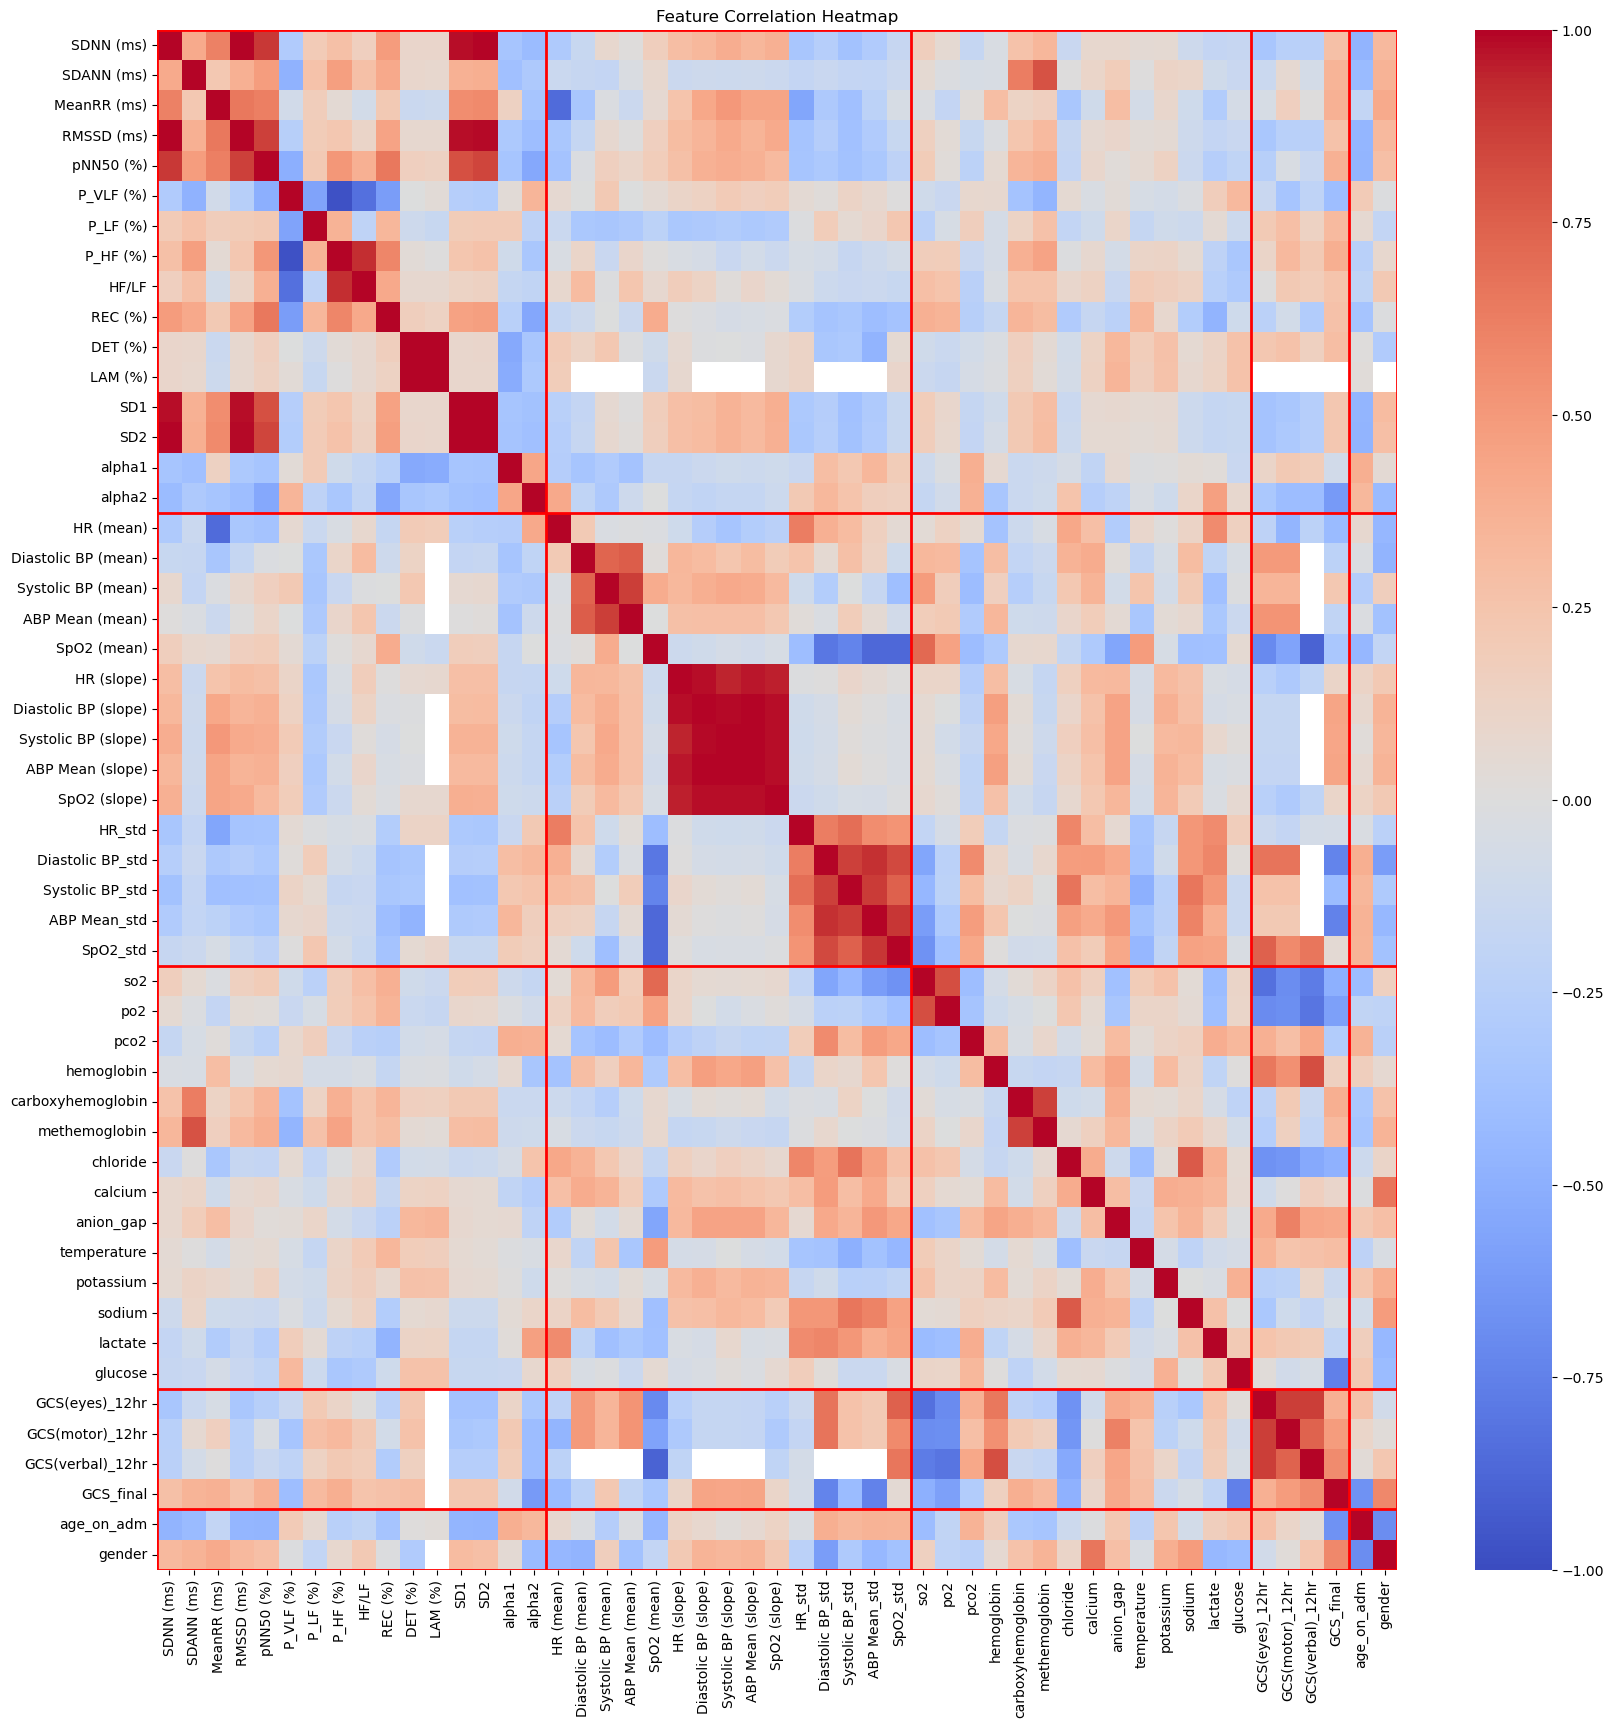

In [17]:
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

# Load and preprocess data
# Merge dataframes
merged_df = hrv.merge(vital, on='patientid', how='inner')
merged_df = merged_df.merge(lab, on='patientid', how='inner')
merged_df = merged_df.merge(gcs, on='patientid', how='inner')
merged_df = merged_df.merge(age, on='patientid', how='inner')
metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']

# Calculate correlation matrix
correlation_matrix = merged_df[metrics].corr()
plt.figure(figsize=(20, 20))
# Visualize correlation matrix as heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)


group_boundaries = [0, 16, 31, 45, 49, 51]

# Add group separation lines
for boundary in group_boundaries:
    plt.axhline(y=boundary, color='r', linewidth=2)
    plt.axvline(x=boundary, color='r', linewidth=2)
    
    
plt.savefig(f'heatmap.png', dpi=100, bbox_inches='tight')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
merged_ = merged_df.drop(columns=['patientid'])

In [9]:
merged_

,SDNN (ms),SDANN (ms),MeanRR (ms),RMSSD (ms),pNN50 (%),P_VLF (s^2/Hz),P_LF (s^2/Hz),P_HF (s^2/Hz),P_VLF (%),P_LF (%),...,GCS(eyes)_final,GCS(motor)_final,GCS(verbal)_final,final from add,Total_add,Total_12hr,GCS_final,age_on_adm,gender,los
0,1327.07,6001.59,282.09,1356.91,0.76,3309.843,3095.212,7033.506,24.629,23.032,...,4.0,6.0,5.0,70.0,13.0,12.0,15.0,24,1.0,68
1,1183.60,6141.06,161.35,1194.64,0.22,7982.744,7335.211,15792.172,25.660,23.578,...,4.0,6.0,4.0,362.0,NaN,3.0,14.0,20,1.0,355
2,14.62,14.43,179.30,179.98,0.00,0.004,0.000,0.000,100.000,0.000,...,4.0,6.0,1.0,165.0,NaN,3.0,11.0,42,1.0,157
3,3946.99,399.79,344.84,3962.83,1.02,268175.571,103890.174,113141.276,55.270,21.412,...,4.0,6.0,4.0,41.0,3.0,3.0,14.0,17,1.0,33
4,48.97,37.25,147.99,155.90,0.14,0.019,0.006,0.004,65.517,20.690,...,4.0,6.0,4.0,150.0,NaN,3.0,14.0,32,1.0,143
5,104.04,83.26,162.15,192.67,0.23,0.010,0.005,0.009,41.667,20.833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,520
6,35.89,28.07,161.70,165.64,0.08,0.023,0.008,0.009,57.500,20.000,...,4.0,6.0,5.0,38.0,3.0,13.0,15.0,51,0.0,29
7,14.92,11.45,145.60,146.38,0.07,6361.963,3199.117,12868.847,28.364,14.263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,NaN,275
8,690.08,750.26,205.08,719.98,0.36,95.674,94.327,266.207,20.972,20.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,43
9,40.34,28.97,244.92,248.25,0.07,0.089,0.023,0.022,66.418,17.164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,44


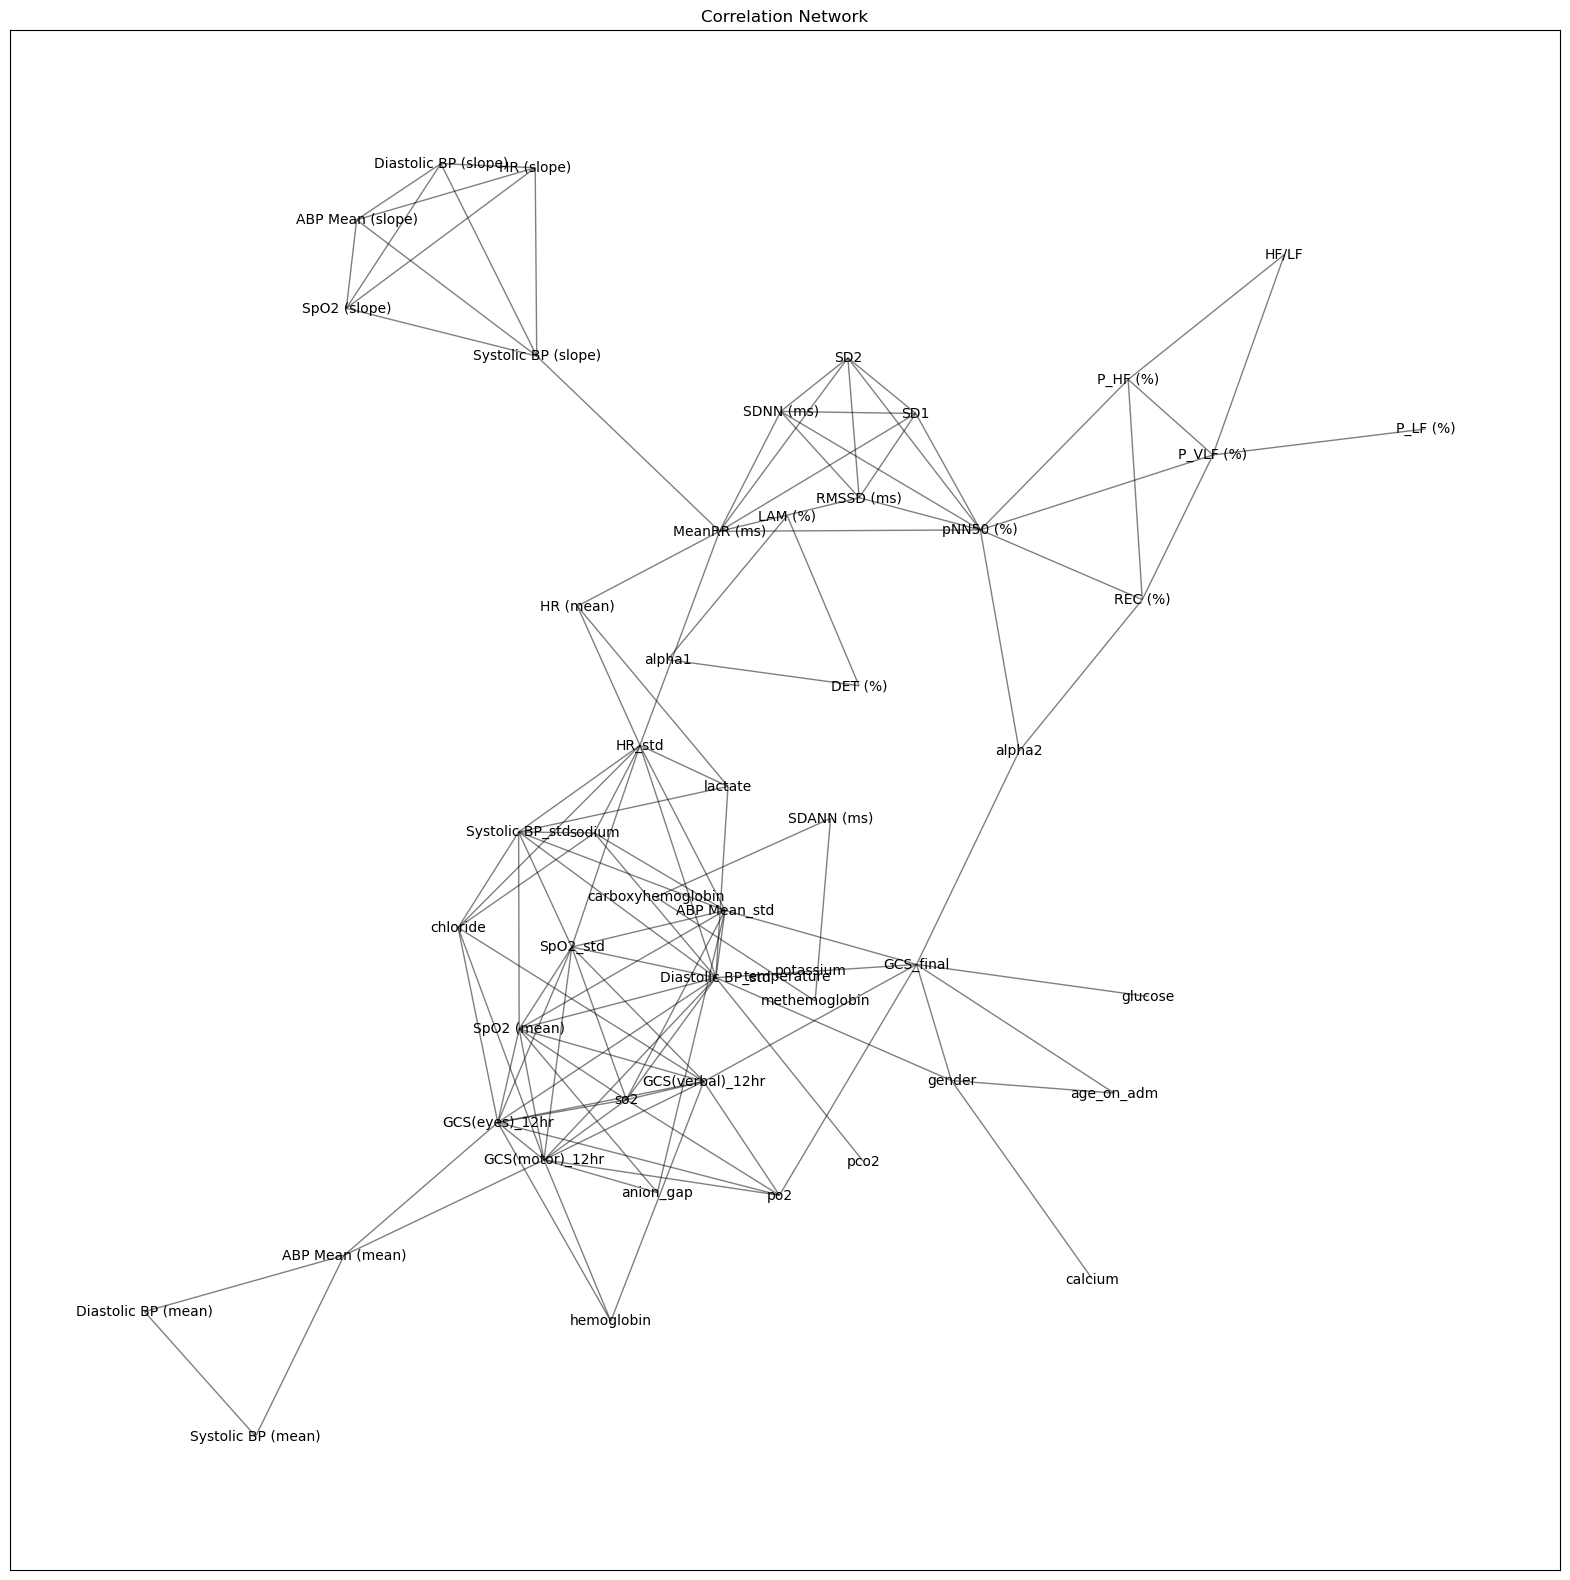

In [10]:
G = nx.Graph()

feature_sets = pd.DataFrame(index=correlation_matrix.columns)
feature_sets['Set'] = 'Other'
feature_sets.loc[feature_sets.index.isin(hrv.columns), 'Set'] = 'hrv'
feature_sets.loc[feature_sets.index.isin(vital.columns), 'Set'] = 'vital'
feature_sets.loc[feature_sets.index.isin(lab.columns), 'Set'] = 'lab'
feature_sets.loc[feature_sets.index.isin(gcs.columns), 'Set'] = 'gcs'
feature_sets.loc[feature_sets.index.isin(age.columns), 'Set'] = 'age'

# Create a color mapping for the sets
set_colors = {'hrv': 'blue', 'vital': 'green', 'lab': 'red', 'gcs': 'gray', 'age':'yellow'}
node_colors = [set_colors[feature_sets.loc[node]['Set']] for node in G.nodes]

# Add nodes (features)
for feature in correlation_matrix.columns:
    G.add_node(feature)

# Add edges (significant correlations)
threshold = 0.5  # Adjust this threshold as needed
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j])

# Visualize network with different node colors
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G)  # Layout algorithm
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Correlation Network")
#plt.savefig(f'corre_network.png', dpi=100, bbox_inches='tight')
plt.show()

In [11]:
!pip install torch torchvision torch-geometric
clear_output(wait=True)
print('Done')

Done


In [12]:
#!pip install community
!pip install python-louvain
clear_output(wait=True)
print('Done')

Done


In [18]:
mer_df = pd.read_csv("s3://hrv-and-others-relationship/features/trauma_final_features/merged_df_flitered_new.csv")

In [19]:
merged_ = mer_df.drop(columns=['patientid'])

In [15]:
!pip install torch_geometric
clear_output(wait=True)
print('Done')

Done


In [16]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.data import Data, DataLoader, Dataset

***New method***

In [20]:
G = nx.Graph()

metrics = ['SDNN (ms)', 'SDANN (ms)', 'MeanRR (ms)', 'RMSSD (ms)', 'pNN50 (%)', 'P_VLF (%)','P_LF (%)','P_HF (%)','HF/LF', 'REC (%)','DET (%)','LAM (%)','SD1', 'SD2', 'alpha1' ,'alpha2',
          'HR (mean)','Diastolic BP (mean)','Systolic BP (mean)','ABP Mean (mean)','SpO2 (mean)','HR (slope)','Diastolic BP (slope)','Systolic BP (slope)','ABP Mean (slope)','SpO2 (slope)','HR_std','Diastolic BP_std','Systolic BP_std','ABP Mean_std','SpO2_std',
          'so2','po2','pco2','hemoglobin','carboxyhemoglobin', 'methemoglobin','chloride','calcium','anion_gap','temperature','potassium','sodium','lactate','glucose',
          'GCS(eyes)_12hr','GCS(motor)_12hr','GCS(verbal)_12hr','GCS_final',
          'age_on_adm','gender']
# Define the subsets and their colors
set_colors = {'hrv': 'blue', 'vital': 'green', 'lab': 'red', 'gcs': 'gray', 'age': 'yellow'}

# Initialize a dictionary to store community assignments for each subset
community_assignments = {subset: {} for subset in set_colors.keys()}

# Add nodes (features) to the graph and assign colors
for feature in merged_[metrics]:
    subset = feature_sets.loc[feature.strip()]['Set']
    G.add_node(feature, color=set_colors[subset])

    

correlation_matrix = merged_[metrics].corr()
# Add edges (significant correlations) with a weight of 1
threshold = 0.5  # Adjust this threshold as needed
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j], weight=1)

# Create a mapping from node names to integers
node_to_index = {node: i for i, node in enumerate(G.nodes)}

# Map the nodes to integers in the edge list
edge_index = torch.tensor([(node_to_index[u], node_to_index[v]) for u, v in G.edges], dtype=torch.long).t().contiguous()


# Convert the adjacency matrix to a dense PyTorch tensor
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = torch.tensor(adjacency_matrix.todense(), dtype=torch.float)

# Print adjacency matrix and edge indices
print("Edge Index Shape:", edge_index.shape)
print("Edge Index Content:", edge_index)
print("Adjacency Matrix:")
print(adjacency_matrix)
print("Edge Indices:")
print(edge_index)


Edge Index Shape: torch.Size([2, 119])
Edge Index Content: tensor([[ 0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  4,  4,  4,  4,  5,  5,  5,  5,  7,  7,  9, 10, 10, 11, 12, 15, 16,
         16, 17, 17, 18, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
         21, 22, 22, 22, 23, 23, 24, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30,
         30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 34, 34, 34, 35, 37, 37, 37,
         37, 38, 39, 44, 45, 45, 46, 47, 48, 48, 49],
        [ 2,  3,  4, 12, 13, 35, 36,  3,  4, 12, 13, 16, 23, 26,  4, 12, 13,  5,
          7,  9, 12, 13, 15,  6,  7,  8,  9,  8,  9, 15, 11, 14, 14, 13, 48, 26,
         43, 18, 19, 19, 45, 46, 27, 28, 29, 30, 31, 39, 45, 46, 47, 22, 23, 24,
         25, 23, 24, 25, 24, 25, 25, 27, 28, 29, 30, 37, 42, 43, 28, 29, 30, 31,
         33, 42, 43, 45, 46, 48, 50, 29, 30, 37, 42, 43, 30, 31, 39, 42, 48, 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


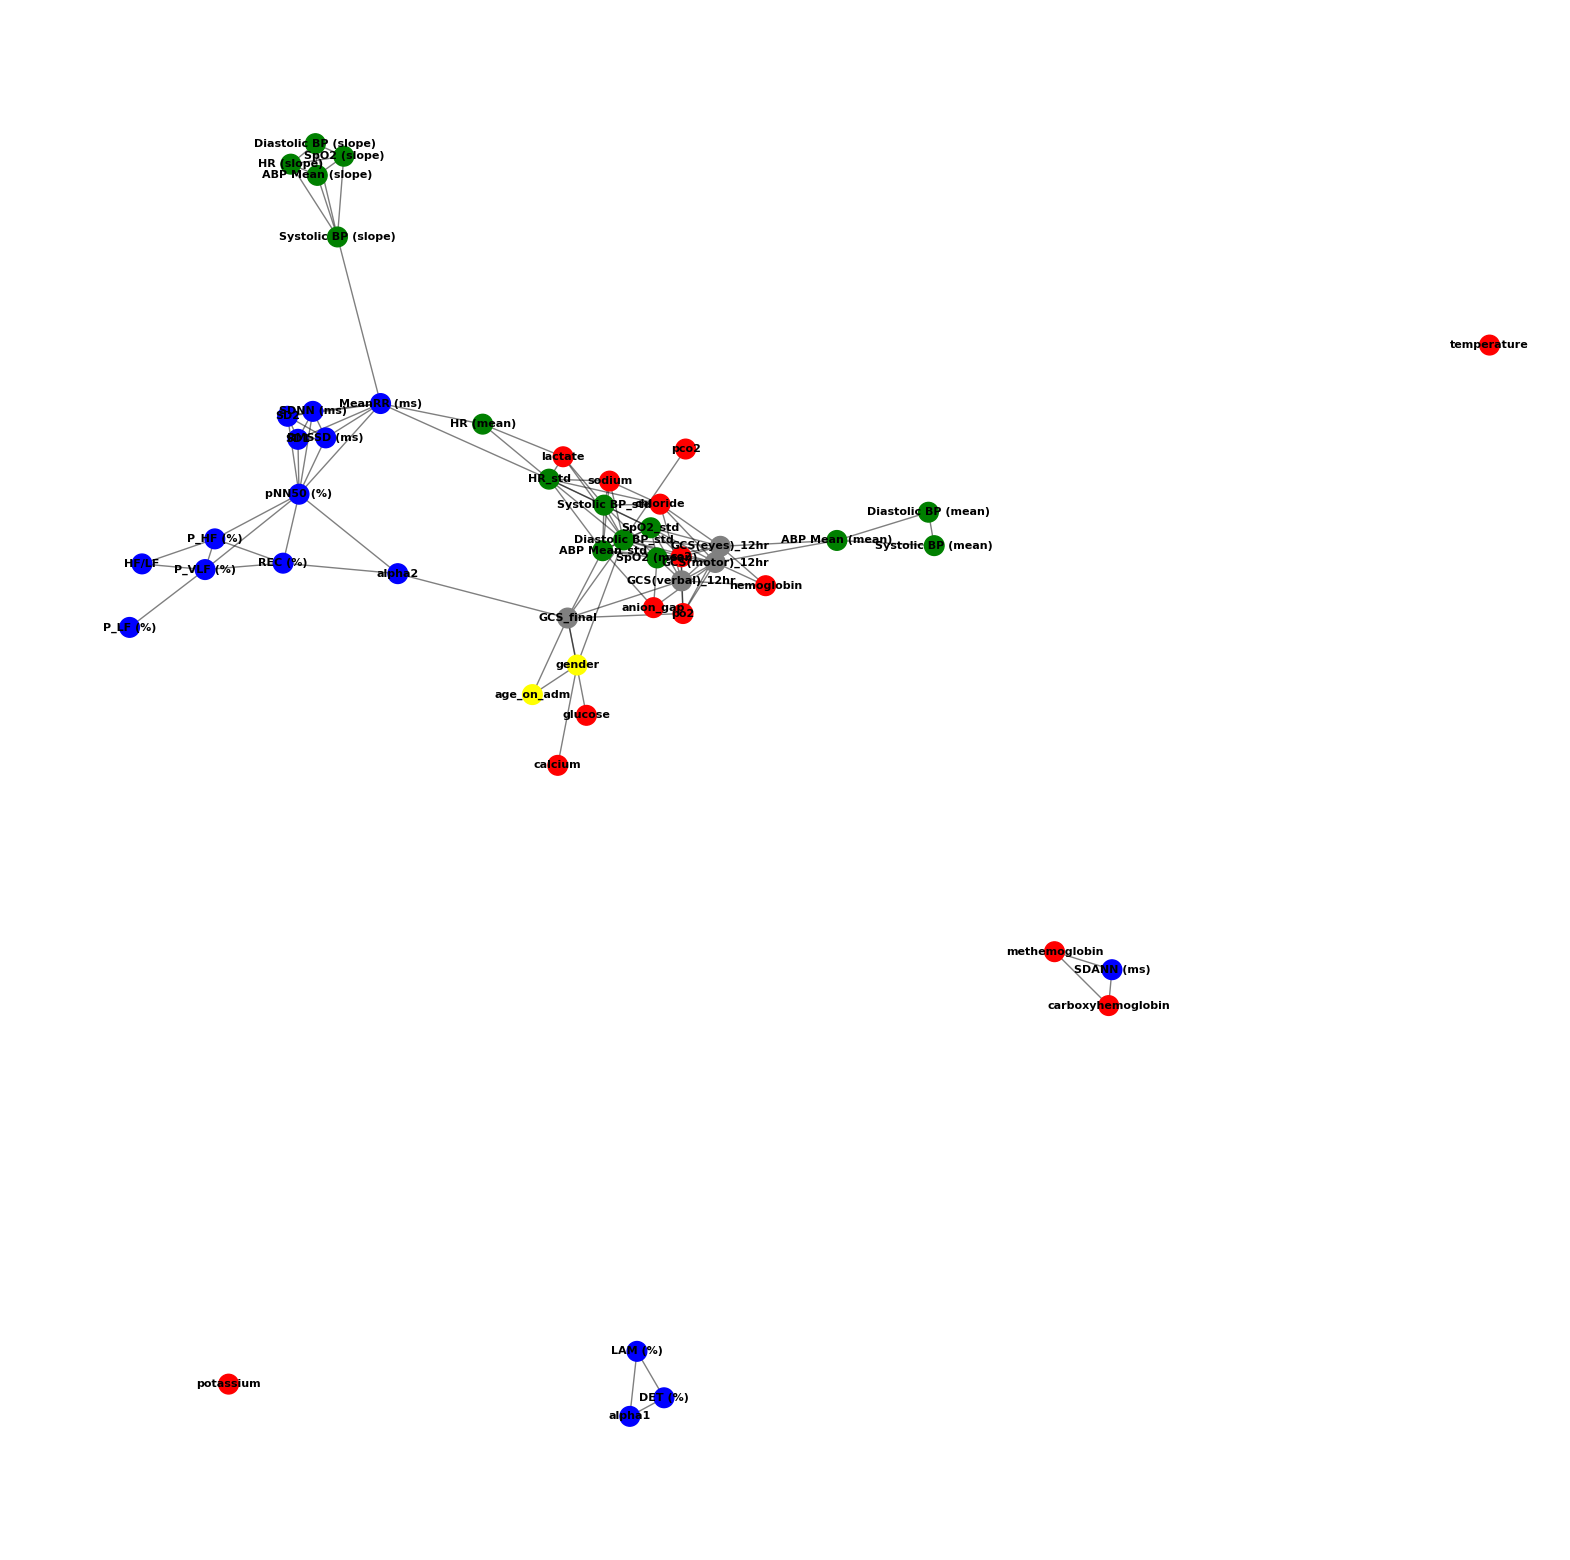

In [21]:
import matplotlib.pyplot as plt

# Compute the layout positions of the nodes using a force-directed layout algorithm
pos = nx.spring_layout(G, seed=42)  # You can choose different layout algorithms as well

# Define node colors based on subsets
node_colors = [node[1]['color'] for node in G.nodes(data=True)]
plt.figure(figsize=(20, 20))
# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

# Draw node labels if needed
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', font_weight='bold')
plt.savefig("gnn_grapg.png") 
plt.axis('off')
plt.show()


***AUTOENCODER METHOD***

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch_geometric.data import Data

class CustomDataset(Dataset):
    def __init__(self, adjacency_matrix, edge_index):
        self.graph_data = Data(x=torch.tensor(adjacency_matrix, dtype=torch.float),
                               edge_index=edge_index)

    def __len__(self):
        return 1  # This dataset contains only one graph

    def __getitem__(self, idx):
        return self.graph_data

# Create a DataLoader for your dataset
dataset = CustomDataset(adjacency_matrix, edge_index)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

/tmp/ipykernel_5070/4064973120.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.graph_data = Data(x=torch.tensor(adjacency_matrix, dtype=torch.float),


In [23]:
def custom_collate(batch):
    # `batch` is a list of Data objects
    return torch_geometric.data.Batch.from_data_list(batch)

# Create a DataLoader with the custom collate function
train_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

In [24]:
#Define the GCN model
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GraphAutoencoder(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GCNConv(num_features, hidden_dim)
        self.decoder = GCNConv(hidden_dim, num_features)

    def forward(self, x, edge_index):
        # Encoder
        x = self.encoder(x, edge_index)
        # Decoder
        x = self.decoder(x, edge_index)
        return x


In [25]:
!pip install torch_geomatric
clear_output(wait=True)
print('Done')

Done


In [26]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch_geometric.nn import GCNConv
import networkx as nx

num_features = adjacency_matrix.shape[0]  # Number of nodes in the graph
hidden_dim = 64
model = GraphAutoencoder(num_features, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1000  # Adjust the number of epochs as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphAutoencoder(num_features, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data = batch.to(device)  # Send the data to the appropriate device (CPU or GPU)
        output = model(data.x, data.edge_index)
        loss = torch.nn.functional.mse_loss(output, data.x)  # Mean Squared Error as the reconstruction loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch: {epoch + 1}, Loss: {average_loss}')

Epoch: 1, Loss: 0.23364734649658203
Epoch: 2, Loss: 0.2167349010705948
Epoch: 3, Loss: 0.20117264986038208
Epoch: 4, Loss: 0.18689574301242828
Epoch: 5, Loss: 0.17384073138237
Epoch: 6, Loss: 0.16194048523902893
Epoch: 7, Loss: 0.15112444758415222
Epoch: 8, Loss: 0.14132027328014374
Epoch: 9, Loss: 0.13245467841625214
Epoch: 10, Loss: 0.12445402890443802
Epoch: 11, Loss: 0.11724520474672318
Epoch: 12, Loss: 0.11075679957866669
Epoch: 13, Loss: 0.104920394718647
Epoch: 14, Loss: 0.09967119991779327
Epoch: 15, Loss: 0.09494879096746445
Epoch: 16, Loss: 0.09069737046957016
Epoch: 17, Loss: 0.08686598390340805
Epoch: 18, Loss: 0.08340858668088913
Epoch: 19, Loss: 0.0802840143442154
Epoch: 20, Loss: 0.07745569944381714
Epoch: 21, Loss: 0.07489147782325745
Epoch: 22, Loss: 0.07256314158439636
Epoch: 23, Loss: 0.07044606655836105
Epoch: 24, Loss: 0.06851869076490402
Epoch: 25, Loss: 0.06676216423511505
Epoch: 26, Loss: 0.0651598572731018
Epoch: 27, Loss: 0.06369700282812119
Epoch: 28, Loss: 0

In [27]:
# Assuming you have a graph G created using networkx

# Step 1: Compute node degrees
node_degrees = dict(G.degree())

# Step 2: Sort nodes based on degrees in descending order
sorted_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)

# Step 3: Get top 20 nodes
top_20_nodes = sorted_nodes[:20]

# Print or use the top 20 nodes as needed
print("Top 20 Nodes based on Degree:", top_20_nodes)


Top 20 Nodes based on Degree: ['Diastolic BP_std', 'GCS(motor)_12hr', 'GCS(eyes)_12hr', 'pNN50 (%)', 'SpO2 (mean)', 'HR_std', 'ABP Mean_std', 'SpO2_std', 'GCS(verbal)_12hr', 'MeanRR (ms)', 'Systolic BP_std', 'so2', 'GCS_final', 'chloride', 'SDNN (ms)', 'RMSSD (ms)', 'P_VLF (%)', 'SD1', 'SD2', 'Systolic BP (slope)']


********************************

*******************************************************************

In [28]:
#node2vec method
!pip install Node2Vec
clear_output(wait=True)
print('Done')

Done


In [29]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model (generate node embeddings)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embeddings for all nodes
node_embeddings = model.wv

Computing transition probabilities:   0%|          | 0/51 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 50/50 [00:00<00:00, 180.86it/s]


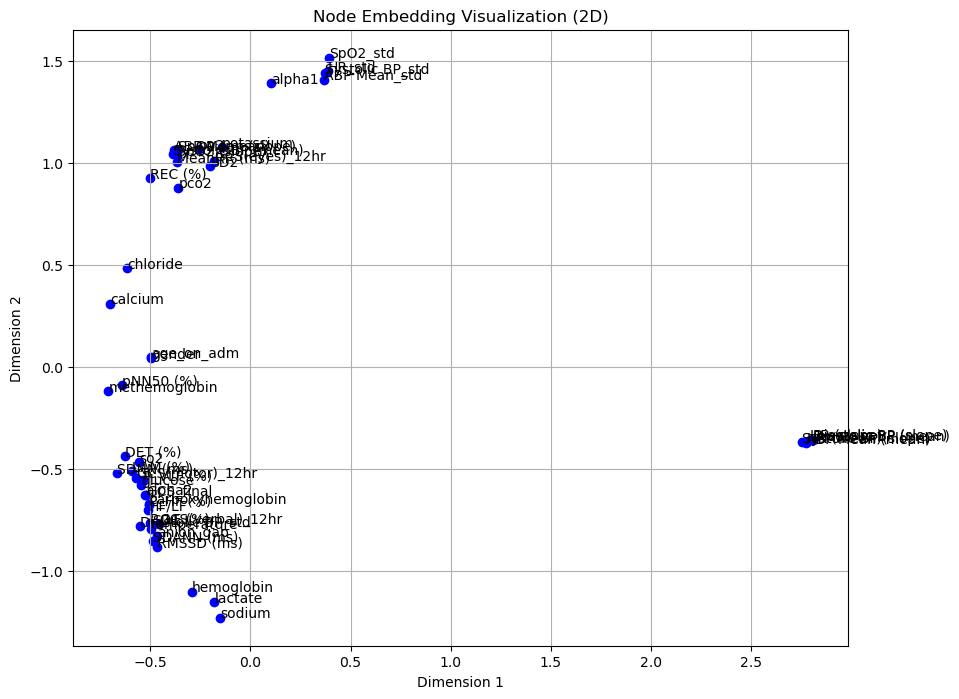

In [30]:
# Reduce dimensionality with PCA
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(node_embeddings.vectors)

# Extract node names (replace with your node labels or IDs)
node_names = list(G.nodes())

# Create a scatter plot for visualization
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c='b', marker='o')

# Annotate nodes with their labels or IDs
for i, txt in enumerate(node_names):
    plt.annotate(txt, (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

plt.title('Node Embedding Visualization (2D)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

***After apply hyperparametwr tuning***

In [31]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return 1  # This dataset contains only one graph

    def __getitem__(self, idx):
        return self.data

def train(model, data, optimizer, criterion, device):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = criterion(output, data.x)  # Mean Squared Error as the reconstruction loss
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, criterion, device):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        loss = criterion(output, data.x)
    return loss.item()

# Define your hyperparameters grid to search
hidden_dims = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 1000
num_classes = 51

# Define your dataset and DataLoader here (assuming you have 'dataset' and 'train_loader')

best_loss = float('inf')
best_params = None

# Grid search for hyperparameter tuning
for hidden_dim in hidden_dims:
    for learning_rate in learning_rates:
        model = GCN(num_features, hidden_dim, num_classes).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()  # Mean Squared Error Loss

        for epoch in range(num_epochs):
            train_loss = train(model, data, optimizer, criterion, device)
            val_loss = evaluate(model, data, criterion, device)
            
            # Print training progress if needed
            # print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_params = {'hidden_dim': hidden_dim, 'learning_rate': learning_rate}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'hidden_dim': 256, 'learning_rate': 0.01}


In [32]:
# Define your GCN model with the best hyperparameters
best_hidden_dim = 256
best_learning_rate = 0.01

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model, send it to the appropriate device, and set up the optimizer
model = GCN(num_features, best_hidden_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Train the model using your full dataset (data) and its edge indices (edge_index) for a certain number of epochs
num_epochs = 10000  # You can adjust the number of epochs based on your dataset and model complexity
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = torch.nn.functional.mse_loss(output, data.x)  # Mean Squared Error as the reconstruction loss
    loss.backward()
    optimizer.step()

# Get node embeddings after training
with torch.no_grad():
    model.eval()
    node_embeddings = model(data.x, data.edge_index)

# Assuming you want to select the top nodes based on L2 norm of embeddings
node_norms = torch.norm(node_embeddings, dim=1)
_, indices = torch.topk(node_norms, k=20, largest=True)
top_20_nodes = list(indices.cpu().numpy())

In [33]:
gcs_final_index = 48

# Calculate L2 norms for node embeddings
node_norms = torch.norm(node_embeddings, dim=1)

# Set the value at 'GCS_final' index to a very large negative number
node_norms[gcs_final_index] = float('-inf')

# Select top 20 features based on L2 norms
_, indices = torch.topk(node_norms, k=20, largest=True)
top_20_nodes = [i.item() for i in indices]

# Map the indices back to feature names based on your graph's node labels
feature_names = [list(G.nodes())[i] for i in top_20_nodes]

print("Top 20 Most Important Features:")
print(feature_names)

Top 20 Most Important Features:
['Diastolic BP_std', 'GCS(motor)_12hr', 'GCS(eyes)_12hr', 'GCS(verbal)_12hr', 'SpO2 (mean)', 'SpO2_std', 'pNN50 (%)', 'ABP Mean_std', 'HR_std', 'MeanRR (ms)', 'so2', 'Systolic BP_std', 'chloride', 'SD2', 'P_VLF (%)', 'SDNN (ms)', 'sodium', 'po2', 'RMSSD (ms)', 'SD1']


In [34]:
top_20_nodes

[27, 46, 45, 47, 20, 30, 4, 29, 26, 2, 31, 28, 37, 13, 5, 0, 42, 32, 3, 12]

In [35]:
# Get top 20 scores for the selected features (nodes)
top_20_scores = [node_norms[i].item() for i in top_20_nodes]

# Print the top 20 scores
print("Top 20 Scores:")
print(top_20_scores)

Top 20 Scores:
[3.5881309509277344, 3.310373544692993, 3.1626100540161133, 3.0005152225494385, 2.998749256134033, 2.9958741664886475, 2.992459774017334, 2.988633155822754, 2.985934257507324, 2.834169864654541, 2.8279850482940674, 2.8078064918518066, 2.446798324584961, 2.239785671234131, 2.2386391162872314, 2.2367022037506104, 2.2347915172576904, 2.234452724456787, 2.23445200920105, 2.2307143211364746]


In [36]:
node_norms

tensor([2.2367, 1.4139, 2.8342, 2.2345, 2.9925, 2.2386, 1.0020, 2.0001, 1.4153,
        2.0043, 1.4125, 1.4144, 2.2307, 2.2398, 1.4126, 1.7306, 1.7305, 1.4131,
        1.4148, 1.9990, 2.9987, 1.9990, 1.9994, 2.2282, 2.0012, 1.9972, 2.9859,
        3.5881, 2.8078, 2.9886, 2.9959, 2.8280, 2.2345, 1.0004, 1.7325, 1.4143,
        1.4139, 2.4468, 1.0006, 1.7331, 0.0048, 0.0048, 2.2348, 1.9978, 1.0002,
        3.1626, 3.3104, 3.0005,   -inf, 1.4147, 1.9969])

In [37]:
len(node_norms)

51

In [38]:
max(node_norms)

tensor(3.5881)

In [39]:
min(node_norms)

tensor(-inf)

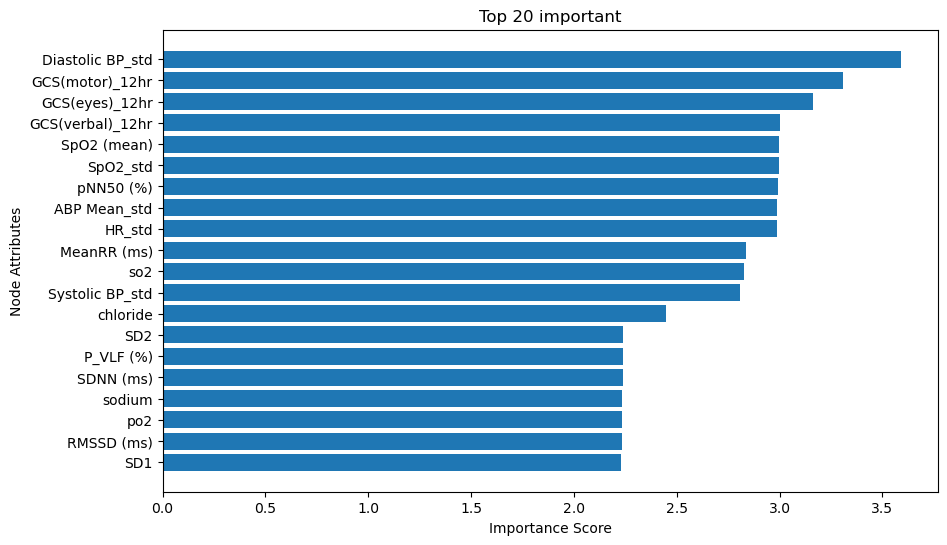

In [40]:
if 'GCS_FINAL' in feature_names:
    feature_names.remove('GCS_FINAL')
    top_20_scores = [score for feature, score in zip(feature_names, top_20_scores) if feature != 'GCS_FINAL']

# Plot the bar chart for the top 20 features and their scores
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(feature_names)), top_20_scores, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Node Attributes')
plt.title('Top 20 important')
plt.gca().invert_yaxis()
plt.savefig(f'feature importance GCN top 20_new.png', dpi=100, bbox_inches='tight')# Invert the y-axis to show the most important feature at the top

plt.show()

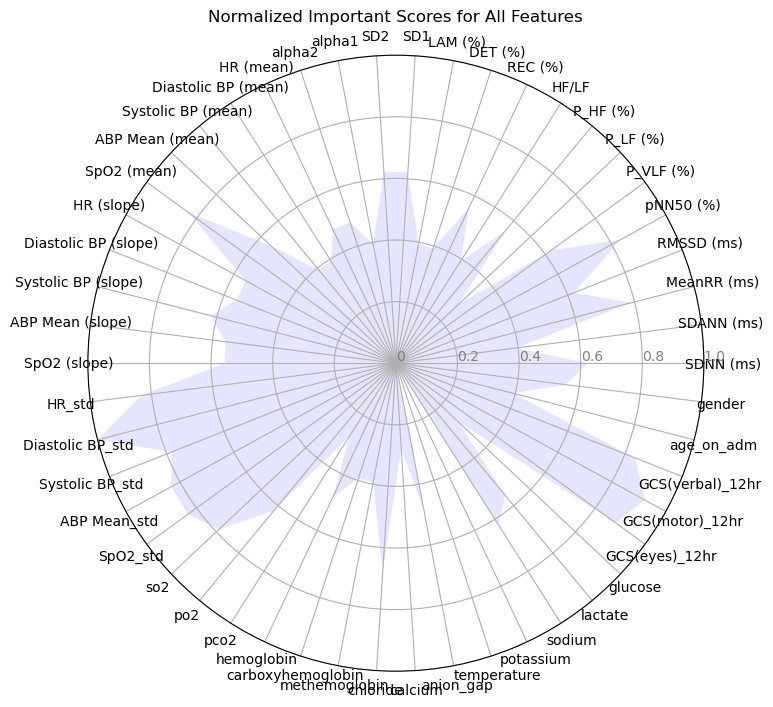

In [41]:
gcs_final_index = 48

# Calculate L2 norms for node embeddings excluding GCS_final index
node_norms = torch.norm(node_embeddings, dim=1)
node_norms[gcs_final_index] = 0.0096  # Set 'GCS_final' index to its actual minimum value

# Exclude GCS_final index from normalized_scores and feature_names
normalized_scores = [(score - node_norms.min()) / (node_norms.max() - node_norms.min()) for i, score in enumerate(node_norms) if i != gcs_final_index]
feature_names = [list(G.nodes())[i] for i in range(len(node_norms)) if i != gcs_final_index]

# Create an array of angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(feature_names), endpoint=False).tolist()

# Duplicate the first angle and append it to match the extra normalized score
angles += angles[:1]

# Create a figure and axis
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Fill the radar plot
ax.fill(angles, normalized_scores + [normalized_scores[0]], 'b', alpha=0.1)  # Append the first score to match the length

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_names)

# Set the y-labels and limit the y-axis to 0-1
ax.set_rlabel_position(0)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)
plt.title('Normalized Important Scores for All Features')
plt.savefig(f'feature_importance_GCN_radar_chart.png')
plt.show()

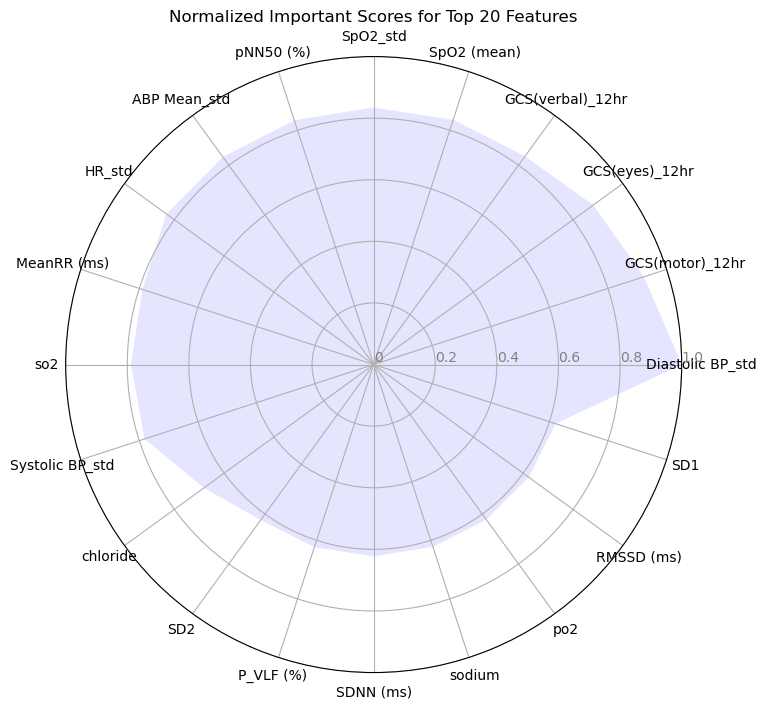

In [42]:
# Sort features based on normalized scores in descending order
sorted_indices = sorted(range(len(normalized_scores)), key=lambda k: normalized_scores[k], reverse=True)

# Select top 20 features
top_20_indices = sorted_indices[:20]
top_20_feature_names = [feature_names[i] for i in top_20_indices]
top_20_normalized_scores = [normalized_scores[i] for i in top_20_indices]

# Create an array of angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(top_20_feature_names), endpoint=False).tolist()
angles += angles[:1]  # Duplicate the first angle to close the radar chart

# Create a figure and axis
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Fill the radar plot for top 20 features
ax.fill(angles, top_20_normalized_scores + [top_20_normalized_scores[0]], 'b', alpha=0.1)  

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(top_20_feature_names)

# Set the y-labels and limit the y-axis to 0-1
ax.set_rlabel_position(0)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
plt.ylim(0, 1)
plt.title('Normalized Important Scores for Top 20 Features')
plt.savefig(f'feature_importance_GCN_top_20_radar_chart.png')
plt.show()


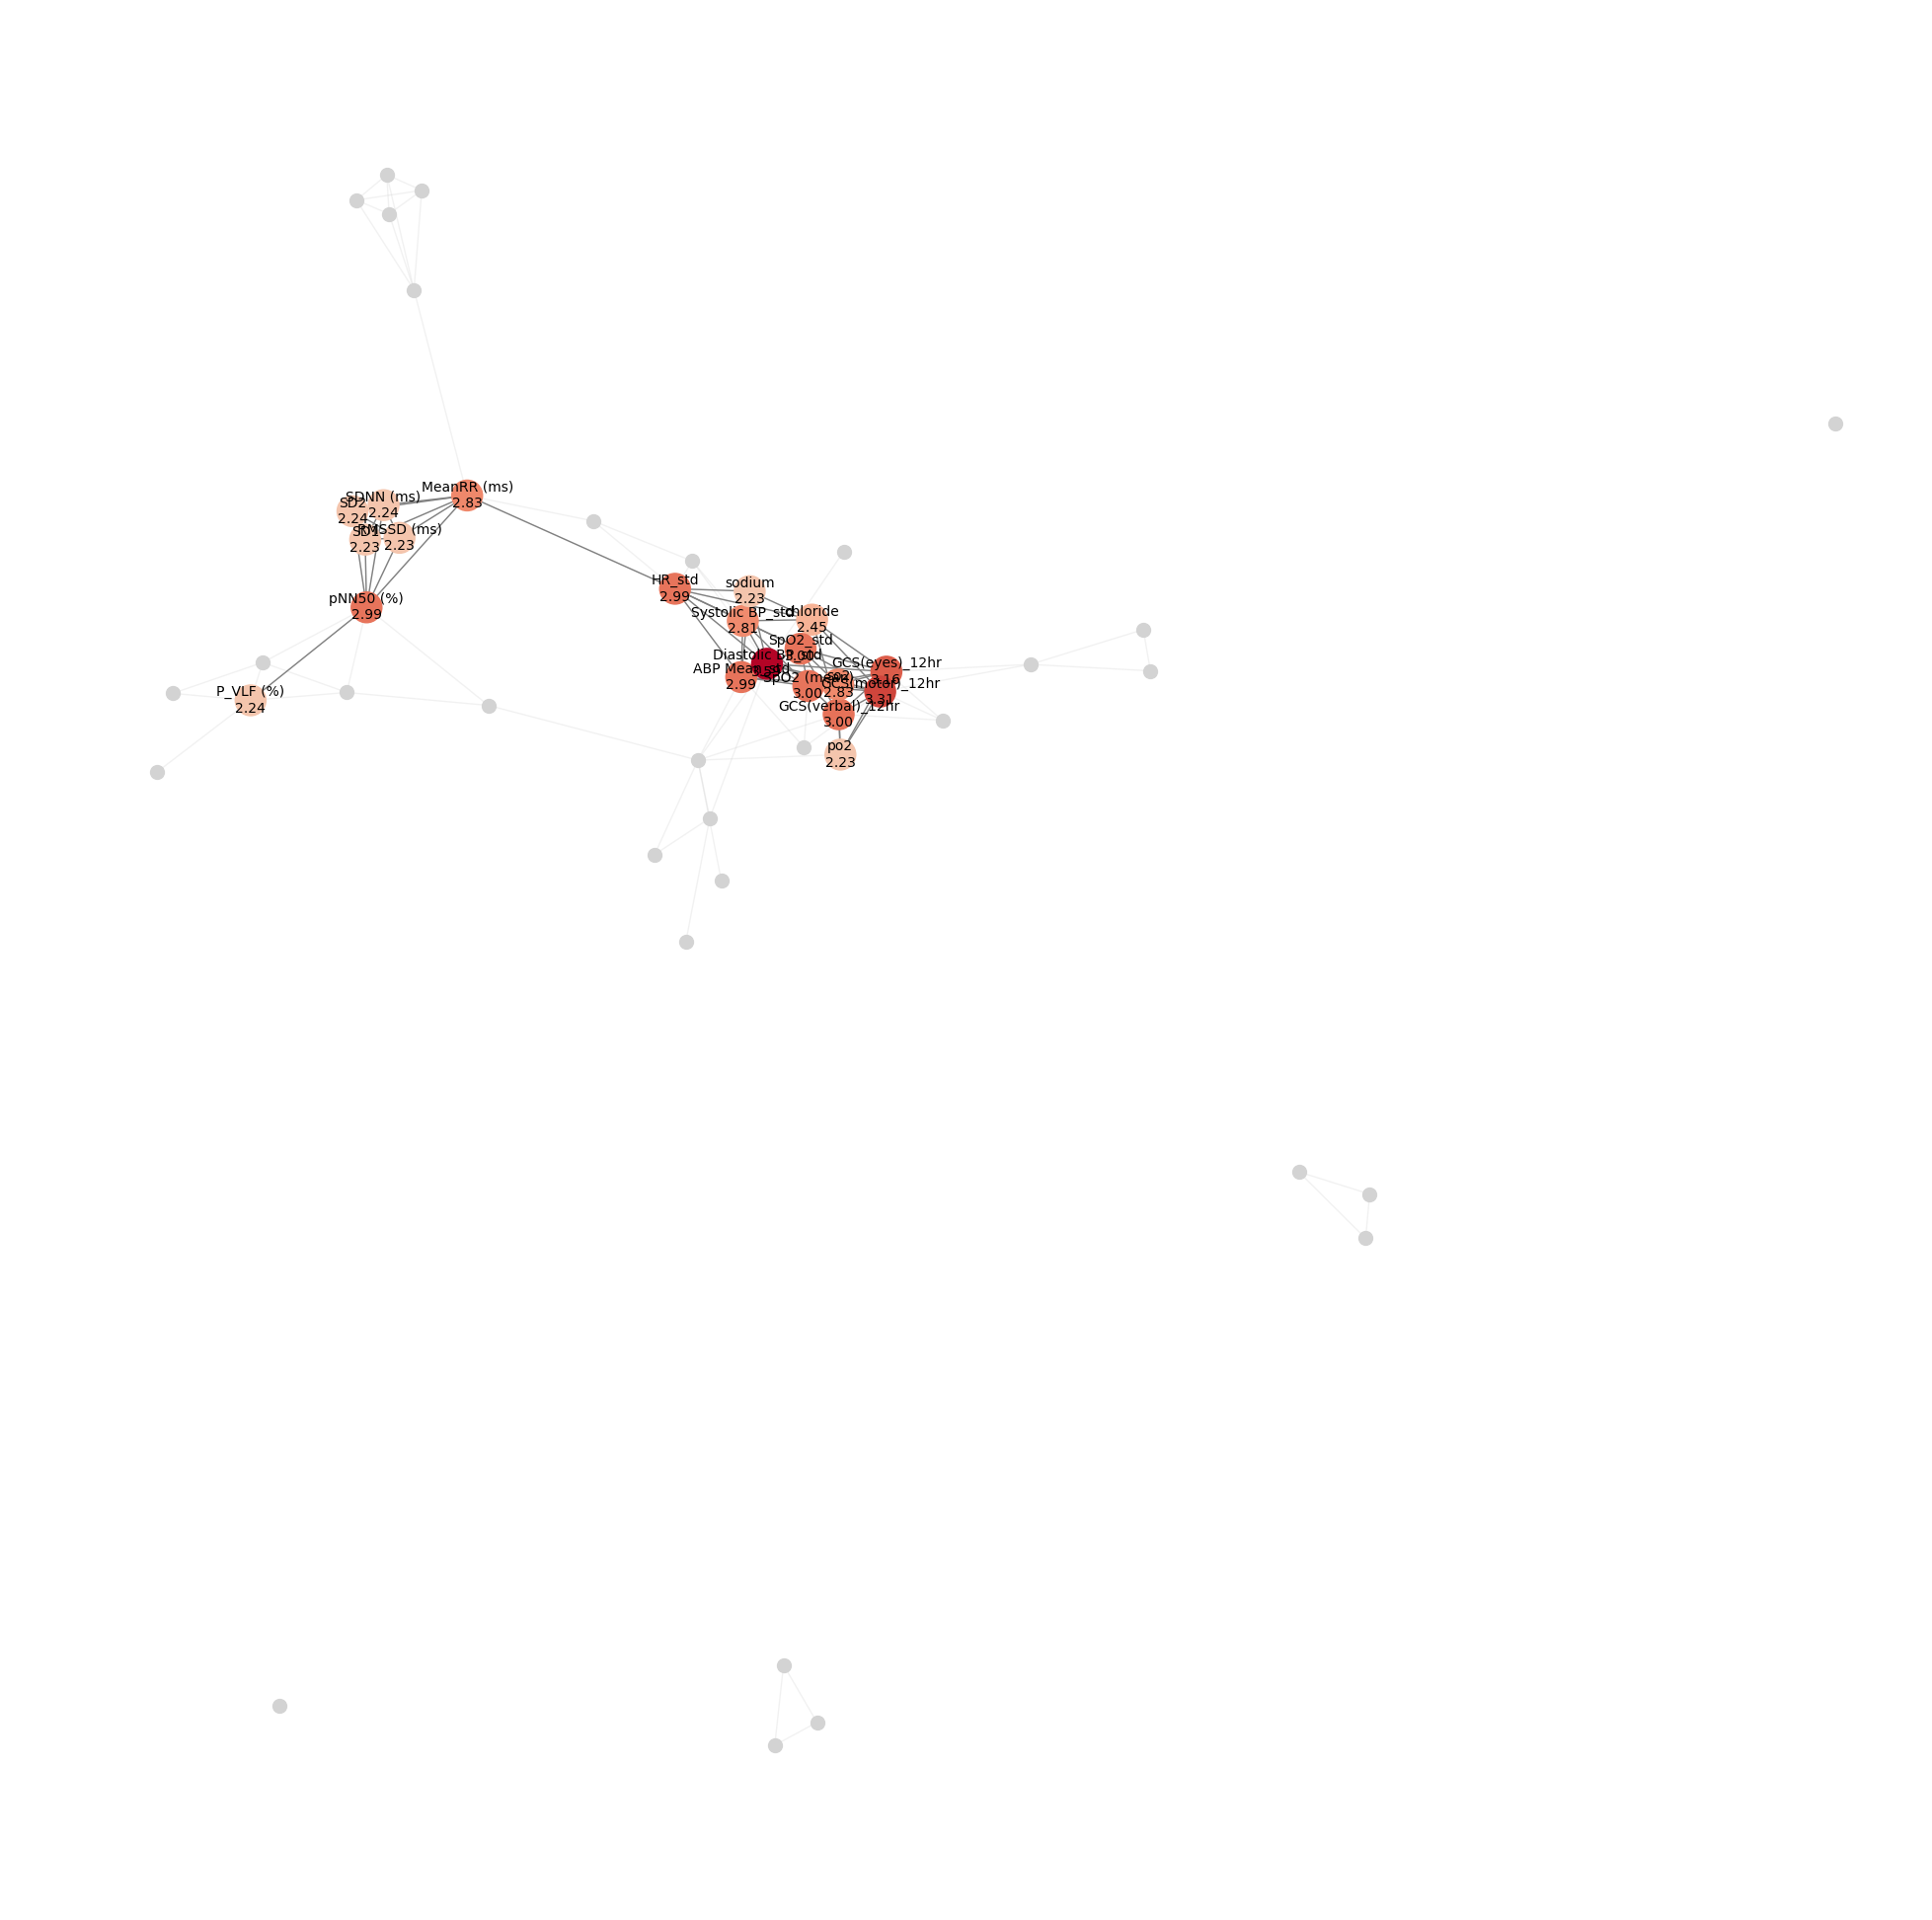

In [43]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Calculate importance scores for nodes in G_top_k
top_k_scores = [node_norms[i].item() for i in indices]

# Create a new graph containing only the top 20 nodes and their edges
top_k_nodes = [list(G.nodes())[i] for i in indices]
G_top_k = G.subgraph(top_k_nodes)

# Define a color map based on importance scores using the 'coolwarm' colormap
color_map = []
for node in G_top_k.nodes():
    if node in top_k_nodes:
        index = top_k_nodes.index(node)
        score = top_k_scores[index]
        # Map the scores to colors using the 'coolwarm' colormap
        color = plt.cm.coolwarm(score / max(top_k_scores))  # coolwarm colormap, normalized to the maximum score
        color_map.append(color)
    else:
        color_map.append('lightgrey')  # Color for nodes not in the top 20

# Draw the entire graph with all edges
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(G, seed=42)

# Draw all nodes with labels and colors based on real importance scores
all_nodes = nx.draw_networkx_nodes(G, pos, node_color='lightgrey', node_size=100)
all_edges = nx.draw_networkx_edges(G, pos, edge_color='lightgrey', alpha=0.3)

# Draw top 20 nodes with labels and colors based on real importance scores
top_nodes = nx.draw_networkx_nodes(G_top_k, pos, node_color=color_map, node_size=500)
top_edges = nx.draw_networkx_edges(G_top_k, pos, edge_color='grey')

# Annotate top 20 nodes with their labels and scores
node_labels = {node: f"{node}\n{score:.2f}" for node, score in zip(top_k_nodes, top_k_scores)}
labels = nx.draw_networkx_labels(G_top_k, pos, labels=node_labels, font_size=10)

# Remove node labels and axis
plt.axis('off')
plt.savefig(f'top 20 GRAPH_new.png')
plt.show()

